# Geolocation of tweets classification

In [1]:
## for data
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns

## for processing
import re
import nltk

## for word embedding
import gensim
import gensim.downloader as gensim_api

import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", message="numpy.dtype size changed")

import multiprocessing

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

/home/yunfe/miniconda3/envs/iml-p3/lib/python3.9/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Read Data

In [2]:
# read the train and dev data
df_train = pd.read_csv('data/train_full.csv')
df_train = df_train[['tweet', 'region']]

df_dev = pd.read_csv('data/dev_full.csv')
df_dev = df_dev[['tweet', 'region']]

df_train.index = range(df_train.shape[0])
df_dev.index = range(df_dev.shape[0])

In [3]:
df_train.shape

(133795, 2)

In [4]:
df_train.sample(10)

,tweet,region
12287,@USER_da4dba38 dm'd? Wth? Lol,MIDWEST
35407,@USER_8752179b @USER_8c22f85f And you know its...,MIDWEST
76810,@USER_59fef649 ari wants to go venus,NORTHEAST
73041,@USER_2f0ad3d1 trevor ariza is better for the ...,NORTHEAST
103686,.@USER_59b459e0 1 of CA's biggest expenses is ...,WEST
16225,@USER_295ab1b6 is that screen gonna be a touch...,SOUTH
79229,"""I wish there was a site for Jewish teens so I...",NORTHEAST
119033,RT @USER_72cdae8d: @USER_25d0ba74 and blair un...,WEST
7456,"@USER_77a8f85d I'ma b lonely wit 2 dogs n $$$,...",SOUTH
81029,I love being with him even when we argued && h...,WEST


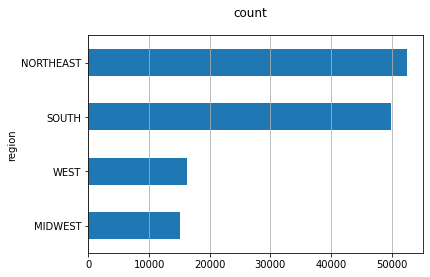

In [5]:
fig, ax = plt.subplots()
fig.suptitle("count", fontsize=12)
df_train["region"].reset_index().groupby("region").count().sort_values(by= 
       "index").plot(kind="barh", legend=False, 
        ax=ax).grid(axis='x')
plt.show()

## Data Engineering

In [6]:
'''
Preprocess a string.
:parameter
    :param text: string - name of column containing text
    :param lst_stopwords: list - list of stopwords to remove
    :param flg_stemm: bool - whether stemming is to be applied
    :param flg_lemm: bool - whether lemmitisation is to be applied
:return
    cleaned text
'''
def utils_preprocess_text(text, flg_stemm=False, flg_lemm=True, lst_stopwords=None):
    
    # remove @mentions (@USER)
#     text = re.sub(r'\B@USER\w+', '', text)
    
    ## clean (convert to lowercase and remove punctuations and characters and then strip)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
            
    ## Tokenize (convert from string to list)
    lst_text = nltk.word_tokenize(text)    
    ## remove Stopwords
    if lst_stopwords is not None:
        lst_text = [word for word in lst_text if word not in 
                    lst_stopwords]
                
    ## Stemming (remove -ing, -ly, ...)
    if flg_stemm == True:
        ps = nltk.stem.porter.PorterStemmer()
        lst_text = [ps.stem(word) for word in lst_text]
                
    ## Lemmatisation (convert the word into root word)
    if flg_lemm == True:
        lem = nltk.stem.wordnet.WordNetLemmatizer()
        lst_text = [lem.lemmatize(word) for word in lst_text]
            
    ## back to string from list
    text = " ".join(lst_text)
    
    return text

In [7]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /home/yunfe/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/yunfe/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/yunfe/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [8]:
lst_stopwords = nltk.corpus.stopwords.words("english")
lst_stopwords

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [9]:
df_train["tweet_clean"] = df_train["tweet"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))
df_train.sample(10)

,tweet,region,tweet_clean
22148,A bunch ah assholeness... Leh me going in my b...,NORTHEAST,bunch ah assholeness leh going bed wh ppl real...
22186,#BBM 3079DAE9 Get At Me!,SOUTH,bbm 3079dae9 get
115048,Fuck yea! RT @USER_e613e67f: LOVE IT! RT @USER...,NORTHEAST,fuck yea rt user_e613e67f love rt user_6e2949f...
80056,#shoutout to my #TTfam @USER_d7b3fb95 -- this ...,SOUTH,shoutout ttfam user_d7b3fb95 must follow imjus...
74179,PEOPLE WHO TYPE IN ALL CAPS JUST WANT ATTENTION,SOUTH,people type cap want attention
93173,@USER_71f8c8df thanks twin,MIDWEST,user_71f8c8df thanks twin
16154,@USER_79491af4 yess ma'am,NORTHEAST,user_79491af4 yes maam
89129,3140ACFF (No DUDES!),NORTHEAST,3140acff dude
12960,@USER_91550f7c yuuup! Catch me if ya can.. ::V...,NORTHEAST,user_91550f7c yuuup catch ya vrooooooooooooooom
44503,"Goodmorning ppl,good to see everyone haven I g...",MIDWEST,goodmorning pplgood see everyone good morningh...


In [10]:
df_dev["tweet_clean"] = df_dev["tweet"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=True, 
          lst_stopwords=lst_stopwords))

## Building Word2Vec Model

In [11]:
cores = multiprocessing.cpu_count()
assert gensim.models.word2vec.FAST_VERSION > -1, "This will be painfully slow otherwise"

### Extract corpus

In [12]:
corpus_train = df_train["tweet_clean"]

## create list of lists of unigrams
lst_corpus_train = []
for string in corpus_train:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_train.append(lst_grams)

In [13]:
lst_corpus_train[:5]

[['watching', 'lost'],
 ['user_89a3500b'],
 ['maneuver', 'put', 'team', 'hopefully', 'sooner', 'live', 'dream'],
 ['darko', 'eating', 'hamburger', 'locker', 'room', 'played', 'knicks', 'lol'],
 ['girl', 'pack', 'ya', 'bag', 'im', 'bout', 'take', 'ride']]

In [14]:
## detect bigrams and trigrams
# bigrams_detector = gensim.models.phrases.Phrases(lst_corpus, delimiter=" ".encode(), min_count=5, threshold=10)
# bigrams_detector = gensim.models.phrases.Phraser(bigrams_detector)
# trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], delimiter=" ".encode(), min_count=5, threshold=10)
# trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

In [15]:
# for the dev data as well
corpus_dev = df_dev["tweet_clean"]

## create list of lists of unigrams
lst_corpus_dev = []
for string in corpus_dev:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_dev.append(lst_grams)

### Build model

In [16]:
model = gensim.models.word2vec.Word2Vec(lst_corpus_train, vector_size=100, window=8, min_count=1, sg=1, epochs=20, workers=cores)

In [17]:
# save the trained model
model.save("./models/word2vec.model")

In [18]:
w2v = dict(zip(model.wv.index_to_key, model.wv))

In [19]:
# now every word is a word-vector
w2v['donald']

array([-0.06774512, -0.14816962,  0.17621005,  0.33268836,  0.05907883,
       -0.2656425 , -0.10598019,  0.21918313, -0.17052585,  0.23545113,
        0.20920493, -0.2029693 , -0.17596179,  0.18369879, -0.0277874 ,
       -0.4078686 , -0.26955852, -0.5336092 , -0.00820513, -0.52968144,
        0.04153088, -0.18102331,  0.1749128 , -0.1204199 , -0.0520412 ,
        0.0574724 , -0.14681876,  0.25412348, -0.2804768 ,  0.00608826,
        0.16467646,  0.11705982,  0.2215864 , -0.37483382, -0.08821878,
        0.02303753, -0.0032479 , -0.04983553, -0.21186511, -0.48913062,
       -0.12018241, -0.06363413, -0.05865871,  0.09006874, -0.12049423,
       -0.11522233,  0.07892998, -0.01900528,  0.51069576,  0.30857173,
        0.01094478,  0.03949932, -0.16969006, -0.01494583,  0.04894175,
        0.31498817,  0.06585271, -0.26974118,  0.01435023, -0.0881516 ,
       -0.06430107,  0.3303579 ,  0.00216886, -0.01905708, -0.2758078 ,
        0.60310227,  0.17387281,  0.34696668, -0.1884546 ,  0.03

In [20]:
model.wv.most_similar(['donald'])

[('trump', 0.8730496764183044),
 ('lawnwit', 0.8397161960601807),
 ('user_c28d47f2', 0.830009937286377),
 ('combover', 0.8218833804130554),
 ('snorting', 0.8043967485427856),
 ('user_f8332890', 0.7982161045074463),
 ('user_8674f459', 0.7913151383399963),
 ('user_62fa06b6', 0.7910611629486084),
 ('peanutbutter', 0.7896377444267273),
 ('situps', 0.7884388566017151)]

In [21]:
len(model.wv['donald'])

100

In [22]:
# transform to embedded vector by averaging the word vectors
def transform(word2vec, words_list):
    return np.array([
        np.mean([word2vec[word] for word in words if word in word2vec]
                or [np.zeros(100)], axis=0)
        for words in words_list
    ])

In [23]:
w2v_vectors_train = transform(w2v, lst_corpus_train)

In [24]:
w2v_vectors_train.shape

(133795, 100)

In [25]:
w2v_vectors_dev = transform(w2v, lst_corpus_dev)

In [26]:
w2v_vectors_dev.shape

(11475, 100)

## Evaluation

In [27]:
x_train = w2v_vectors_train
y_train = df_train['region']

In [28]:
x_dev = w2v_vectors_dev
y_dev = df_dev['region']

In [29]:
assert(len(x_train)==len(y_train))
assert(len(x_dev)==len(y_dev))

### Logistic Regression

In [30]:
lr_clf = LogisticRegression().fit(x_train, y_train)

In [31]:
lr_predictions = lr_clf.predict(x_dev)

In [32]:
lr_acc = accuracy_score(y_dev, lr_predictions)
lr_f1 = f1_score(y_dev, lr_predictions, average='macro')

print(f"LR \t\tAccuracy: {round(lr_acc, 2)}\tMacro F1: {round(lr_f1, 2)}")

LR 		Accuracy: 0.45	Macro F1: 0.26


### Extra Trees Classifier

In [33]:
et_clf = ExtraTreesClassifier(n_estimators=100, random_state=0).fit(x_train, y_train)

In [34]:
et_predictions = et_clf.predict(x_dev)

In [35]:
et_acc = accuracy_score(y_dev, et_predictions)
et_f1 = f1_score(y_dev, et_predictions, average='macro')

print(f"ExtraTrees \t\tAccuracy: {round(et_acc, 2)}\tMacro F1: {round(et_f1, 2)}")

ExtraTrees 		Accuracy: 0.43	Macro F1: 0.25


### Perceptron

In [34]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score

In [35]:
per_clf = MLPClassifier(max_iter=200, verbose=True)

print('corss-val acc:', np.mean(cross_val_score(per_clf, x_train, y_train, cv=5)))
per_clf.fit(x_train, y_train)

Iteration 1, loss = 1.20474903
Iteration 2, loss = 1.18622760
Iteration 3, loss = 1.17965831
Iteration 4, loss = 1.17475777
Iteration 5, loss = 1.17064095
Iteration 6, loss = 1.16658012
Iteration 7, loss = 1.16350200
Iteration 8, loss = 1.16034639
Iteration 9, loss = 1.15729543
Iteration 10, loss = 1.15471909
Iteration 11, loss = 1.15200088
Iteration 12, loss = 1.14941628
Iteration 13, loss = 1.14743245
Iteration 14, loss = 1.14579632
Iteration 15, loss = 1.14338944
Iteration 16, loss = 1.14198371
Iteration 17, loss = 1.14001481
Iteration 18, loss = 1.13852369
Iteration 19, loss = 1.13673927
Iteration 20, loss = 1.13571929
Iteration 21, loss = 1.13414519
Iteration 22, loss = 1.13319212
Iteration 23, loss = 1.13192619
Iteration 24, loss = 1.13095931
Iteration 25, loss = 1.12919789
Iteration 26, loss = 1.12855266
Iteration 27, loss = 1.12752073
Iteration 28, loss = 1.12641187
Iteration 29, loss = 1.12566293
Iteration 30, loss = 1.12497286
Iteration 31, loss = 1.12371240
Iteration 32, los

Iteration 55, loss = 1.10820509
Iteration 56, loss = 1.10807089
Iteration 57, loss = 1.10788806
Iteration 58, loss = 1.10749958
Iteration 59, loss = 1.10670247
Iteration 60, loss = 1.10619447
Iteration 61, loss = 1.10606675
Iteration 62, loss = 1.10584148
Iteration 63, loss = 1.10482582
Iteration 64, loss = 1.10452497
Iteration 65, loss = 1.10503086
Iteration 66, loss = 1.10420955
Iteration 67, loss = 1.10407935
Iteration 68, loss = 1.10358420
Iteration 69, loss = 1.10306565
Iteration 70, loss = 1.10321563
Iteration 71, loss = 1.10269065
Iteration 72, loss = 1.10236084
Iteration 73, loss = 1.10184244
Iteration 74, loss = 1.10168232
Iteration 75, loss = 1.10107675
Iteration 76, loss = 1.10113448
Iteration 77, loss = 1.10053066
Iteration 78, loss = 1.10079512
Iteration 79, loss = 1.09983875
Iteration 80, loss = 1.09985463
Iteration 81, loss = 1.09997864
Iteration 82, loss = 1.09944724
Iteration 83, loss = 1.09928140
Iteration 84, loss = 1.09883200
Iteration 85, loss = 1.09895742
Iteratio

Iteration 108, loss = 1.09434948
Iteration 109, loss = 1.09450765
Iteration 110, loss = 1.09442066
Iteration 111, loss = 1.09395750
Iteration 112, loss = 1.09334317
Iteration 113, loss = 1.09375128
Iteration 114, loss = 1.09359828
Iteration 115, loss = 1.09357421
Iteration 116, loss = 1.09339230
Iteration 117, loss = 1.09312279
Iteration 118, loss = 1.09290808
Iteration 119, loss = 1.09288474
Iteration 120, loss = 1.09248419
Iteration 121, loss = 1.09187493
Iteration 122, loss = 1.09254215
Iteration 123, loss = 1.09195430
Iteration 124, loss = 1.09227836
Iteration 125, loss = 1.09197253
Iteration 126, loss = 1.09133517
Iteration 127, loss = 1.09149376
Iteration 128, loss = 1.09125659
Iteration 129, loss = 1.09153873
Iteration 130, loss = 1.09094886
Iteration 131, loss = 1.09092735
Iteration 132, loss = 1.09061190
Iteration 133, loss = 1.09047086
Iteration 134, loss = 1.09017974
Iteration 135, loss = 1.09082538
Iteration 136, loss = 1.08976676
Iteration 137, loss = 1.09020149
Iteration 

Iteration 160, loss = 1.08442842
Iteration 161, loss = 1.08414198
Iteration 162, loss = 1.08425199
Iteration 163, loss = 1.08447088
Iteration 164, loss = 1.08382221
Iteration 165, loss = 1.08344135
Iteration 166, loss = 1.08341611
Iteration 167, loss = 1.08374803
Iteration 168, loss = 1.08370573
Iteration 169, loss = 1.08324720
Iteration 170, loss = 1.08319691
Iteration 171, loss = 1.08296200
Iteration 172, loss = 1.08273188
Iteration 173, loss = 1.08333068
Iteration 174, loss = 1.08283850
Iteration 175, loss = 1.08286520
Iteration 176, loss = 1.08226930
Iteration 177, loss = 1.08264010
Iteration 178, loss = 1.08247206
Iteration 179, loss = 1.08271013
Iteration 180, loss = 1.08212598
Iteration 181, loss = 1.08271919
Iteration 182, loss = 1.08206236
Iteration 183, loss = 1.08177360
Iteration 184, loss = 1.08190535
Iteration 185, loss = 1.08283624
Iteration 186, loss = 1.08235191
Iteration 187, loss = 1.08176956
Iteration 188, loss = 1.08185618
Iteration 189, loss = 1.08172913
Iteration 

Iteration 12, loss = 1.15199900
Iteration 13, loss = 1.15010145
Iteration 14, loss = 1.14843112
Iteration 15, loss = 1.14718730
Iteration 16, loss = 1.14504910
Iteration 17, loss = 1.14444894
Iteration 18, loss = 1.14308488
Iteration 19, loss = 1.14156112
Iteration 20, loss = 1.14043066
Iteration 21, loss = 1.13906148
Iteration 22, loss = 1.13818002
Iteration 23, loss = 1.13691099
Iteration 24, loss = 1.13632888
Iteration 25, loss = 1.13540566
Iteration 26, loss = 1.13444101
Iteration 27, loss = 1.13365011
Iteration 28, loss = 1.13280592
Iteration 29, loss = 1.13189787
Iteration 30, loss = 1.13086470
Iteration 31, loss = 1.13039021
Iteration 32, loss = 1.12933600
Iteration 33, loss = 1.12905151
Iteration 34, loss = 1.12799712
Iteration 35, loss = 1.12749430
Iteration 36, loss = 1.12648558
Iteration 37, loss = 1.12652385
Iteration 38, loss = 1.12576506
Iteration 39, loss = 1.12476773
Iteration 40, loss = 1.12498810
Iteration 41, loss = 1.12446582
Iteration 42, loss = 1.12405212
Iteratio

MLPClassifier(verbose=True)

In [38]:
per_predictions = per_clf.predict(x_dev)

In [39]:
per_acc = accuracy_score(y_dev, per_predictions)
per_f1 = f1_score(y_dev, per_predictions, average='macro')

print(f"ExtraTrees \t\tAccuracy: {round(per_acc, 2)}\tMacro F1: {round(per_f1, 2)}")

ExtraTrees 		Accuracy: 0.45	Macro F1: 0.27


### Neural Networks

In [42]:
## for deep learning
from tensorflow.keras import models, layers, preprocessing as kprocessing
from tensorflow.keras import backend as K

In [43]:
## tokenize text
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', 
                     oov_token="NaN", 
                     filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(lst_corpus_train)
dic_vocabulary = tokenizer.word_index 

## create sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_train)

## padding sequence
X_train = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [44]:
X_train.shape

(133795, 15)

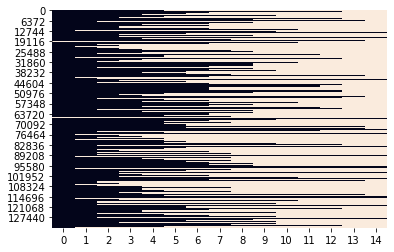

In [45]:
sns.heatmap(X_train==0, vmin=0, vmax=1, cbar=False)
plt.show()

In [46]:
i = 100

## list of text: ["I like this", ...]
len_txt = len(df_train["tweet_clean"].iloc[i].split())
print("from: ", df_train["tweet_clean"].iloc[i], "| len:", len_txt)

## sequence of token ids: [[1, 2, 3], ...]
len_tokens = len(X_train[i])
print("to: ", X_train[i], "| len:", len(X_train[i]))

## vocabulary: {"I":1, "like":2, "this":3, ...}
print("check: ", df_train["tweet_clean"].iloc[i].split()[0], 
      " -- idx in vocabulary -->", 
      dic_vocabulary[df_train["tweet_clean"].iloc[i].split()[0]])

print("vocabulary: ", dict(list(dic_vocabulary.items())[0:5]), "... (padding element, 0)")

from:  lol see martial art master never return anger kuhai even battle u hope learned lesson | len: 15
to:  [    4    22  8770  2002  2509    70  1400  3825 25549    86  1867     3
   143  1565  2378] | len: 15
check:  lol  -- idx in vocabulary --> 4
vocabulary:  {'NaN': 1, 'rt': 2, 'u': 3, 'lol': 4, 'im': 5} ... (padding element, 0)


In [48]:
tokenizer.fit_on_texts(lst_corpus_dev)
dic_vocabulary = tokenizer.word_index 

## create sequence
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus_dev)

## padding sequence
X_dev = kprocessing.sequence.pad_sequences(lst_text2seq, 
                    maxlen=15, padding="post", truncating="post")

In [49]:
## start the matrix (length of vocabulary x vector size) with all 0s
embeddings = np.zeros((len(dic_vocabulary)+1, 300))

for word,idx in dic_vocabulary.items():
    ## update the row with vector
    try:
        embeddings[idx] =  w2v[word]
    ## if word not in model then skip and the row stays all 0s
    except:
        pass

#### Build deep learning model

In [50]:
## code attention layer
def attention_layer(inputs, neurons):
    x = layers.Permute((2,1))(inputs)
    x = layers.Dense(neurons, activation="softmax")(x)
    x = layers.Permute((2,1), name="attention")(x)
    x = layers.multiply([inputs, x])
    return x
## input
x_in = layers.Input(shape=(15,))## embedding
x = layers.Embedding(input_dim=embeddings.shape[0],  
                     output_dim=embeddings.shape[1], 
                     weights=[embeddings],
                     input_length=15, trainable=False)(x_in)## apply attention
x = attention_layer(x, neurons=15)## 2 layers of bidirectional lstm
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                         return_sequences=True))(x)
x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)## final dense layers
x = layers.Dense(64, activation='relu')(x)
y_out = layers.Dense(3, activation='softmax')(x)## compile
model = models.Model(x_in, y_out)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])

model.summary()

NotImplementedError: Cannot convert a symbolic Tensor (bidirectional/forward_lstm/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported

## Testing

In [51]:
best_predictor = lr_clf

In [52]:
df_test = pd.read_csv('data/test_full.csv')
df_test = df_test[['tweet']]

df_test.index = range(df_test.shape[0])

In [53]:
df_test.shape

(12018, 1)

In [54]:
df_test.sample(5)

,tweet
9837,Finna go to sleep.....but one note tho like my...
1707,Better to do? I'm walking out this crazy libra...
753,@USER_6169045c HEY!!!
7062,"Aye OLD drunk ladies are funny, they always wa..."
7856,RT @USER_30df73b1: its y.o.e or nuffin u figru...


In [55]:
df_test["tweet_clean"] = df_test["tweet"].apply(lambda x: 
          utils_preprocess_text(x, flg_stemm=False, flg_lemm=False, 
          lst_stopwords=lst_stopwords))
df_test.sample(5)

,tweet,tweet_clean
4838,On my way out wit the fam!!,way wit fam
5761,#iBlockedYouBecause u might trick me once but ...,iblockedyoubecause u might trick wont let u tr...
3348,@USER_a2152876 I'm good you,im good
4420,@USER_37af4b80 lmao my bad...tryna get some at...,lmao badtryna get attention
5338,@USER_81e70e70 lmfao yeaaa u right boo I'll co...,lmfao yeaaa u right boo ill come see person


In [56]:
df_test.shape

(12018, 2)

In [57]:
# for the test data as well
corpus_test = df_test["tweet_clean"]

## create list of lists of unigrams
lst_corpus_test = []
for string in corpus_test:
    lst_words = string.split()
    lst_grams = [" ".join(lst_words[i:i+1]) for i in range(0, len(lst_words), 1)]
    lst_corpus_test.append(lst_grams)

In [58]:
len(lst_corpus_test)

12018

In [59]:
w2v_vectors_test = transform(w2v, lst_corpus_test)
x_test = w2v_vectors_test

In [60]:
x_test.shape

(12018, 300)

In [61]:
predictions = best_predictor.predict(x_test)

In [62]:
result = pd.DataFrame(predictions, columns=['region'])
result.index.name = "id"
result.index += 1

In [63]:
result.to_csv('result.csv')